# GCNAE: training animations

## Imports and setup

In [1]:
import time
import random
import os
from collections import defaultdict

import numpy as np
import scipy as sp
import scipy.stats
from scipy import linalg
import sklearn.preprocessing
import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
import seaborn as sb
import networkx as nx

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback as TQDMCallback

from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers
from nw2vec import viz
from nw2vec import batching

Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
MODEL_NAME = 'vae-explore'

In [3]:
random.seed(1)
np.random.seed(1)

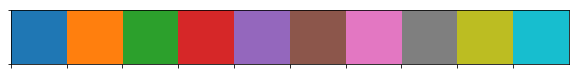

In [4]:
sb.palplot(sb.color_palette())
blue, orange, green, red, purple = sb.color_palette(n_colors=5)

### Model drawing routines

In [5]:
def plot_ξ_distribution(glk, q_model, adj, features, with_kdes=True, fig=None):
    g, l, k = glk
    n_axes = 3 if with_kdes else 2
    palette = np.concatenate([np.array(sb.color_palette(n_colors=l)),
                              .5 * np.ones((l, 1))],
                             axis=1)
    communities = ([[i] for i in range(l)] * np.ones((l, k), dtype=np.int32)).reshape(-1)
    
    if fig is None:
        fig, axes = plt.subplots(1, n_axes, figsize=(4 * n_axes, 4),
                                 subplot_kw=dict(aspect='equal'))#, sharex=True, sharey=True)
    else:
        axes = fig.axes
        assert len(axes) >= 3 if with_kdes else 2

    x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                        adj.shape[0], 1,
                                        p=1, q=1, neighbour_samples=None))
    q_pred = q_model.predict_on_fed_batch(x, feeds=feeds)

    # μ plots
    q_pred_μ = q_pred[:, :2]
    max_mu = np.abs(q_pred_μ).max()
    c_radius = max_mu / (20 - 4)
    circles = [Circle(xy, c_radius, color=palette[communities[i]]) for i, xy in enumerate(q_pred_μ)]
    texts = []
    for i, (x, y) in enumerate(q_pred_μ):
        axes[0].add_artist(circles[i])
        texts.append(axes[0].text(x, y, str(i), ha='center', va='center', color='white'))
    axes[0].set_title(r'$\mu = \left<\xi\right>$ for each node')
    axes[0].set_xlim(- (max_mu + 2 * c_radius), max_mu + 2 * c_radius)
    axes[0].set_ylim(- (max_mu + 2 * c_radius), max_mu + 2 * c_radius)

    # Ellipse plots
    embedding_codec = codecs.Gaussian(q_pred)
    R = K.eval(embedding_codec.R)
    C = R @ R.transpose([0, 2, 1])

    evals, evecs = zip(*[linalg.eigh(c) for c in C])
    evals = np.array(evals)
    evecs = np.array(evecs)

    e_widths = 3 * 2 * np.sqrt(evals[:, 0])
    e_heights = 3 * 2 * np.sqrt(evals[:, 1])
    e_angles = 180 * np.arctan(evecs[:, 0, 1] / evecs[:, 0, 0]) / np.pi
    ellipses = [Ellipse(q_pred[i, :2], e_widths[i], e_heights[i], e_angles[i],
                        color=palette[communities[i]], alpha=.1)
                for i in range(n_nodes)]
    for ellipse in ellipses:
        axes[1].add_artist(ellipse)
    axes[1].set_title(r'$3 \sigma$ ellipse for each node')
    max_ellipse_radius = max(e_widths.max(), e_heights.max()) / 2
    xylim_sigma = max_ellipse_radius + max_mu
    axes[1].set_xlim(-xylim_sigma, xylim_sigma)
    axes[1].set_ylim(-xylim_sigma, xylim_sigma)
    
    # KDE plots
    if with_kdes:
        q_pred_ξ_sample = K.eval(codecs.Gaussian(q_pred).stochastic_value(100))
        for i in range(l):
            x = q_pred_ξ_sample[i * k:(i + 1) * k, :, 0].flatten()
            y = q_pred_ξ_sample[i * k:(i + 1) * k, :, 1].flatten()
            sb.kdeplot(x, y, cmap=sb.light_palette(palette[i], as_cmap=True),
                       shade=True, shade_lowest=False, ax=axes[2])
        axes[2].set_title(r'$\xi$ density for each community (flat nodes+sampling)')
        
    # Box representing the μ plots in the KDE and Ellipse plots
    lines = []
    lines.append(axes[1].hlines(axes[0].get_ylim(), *axes[0].get_xlim(), colors='lightgrey'))
    lines.append(axes[1].vlines(axes[0].get_xlim(), *axes[0].get_ylim(), colors='lightgrey'))
    if with_kdes:
        lines.append(axes[2].hlines(axes[0].get_ylim(), *axes[0].get_xlim(), colors='lightgrey'))
        lines.append(axes[2].vlines(axes[0].get_xlim(), *axes[0].get_ylim(), colors='lightgrey'))
    
    fig.tight_layout()
    return fig, (circles, texts, ellipses, lines)

## Test graphs

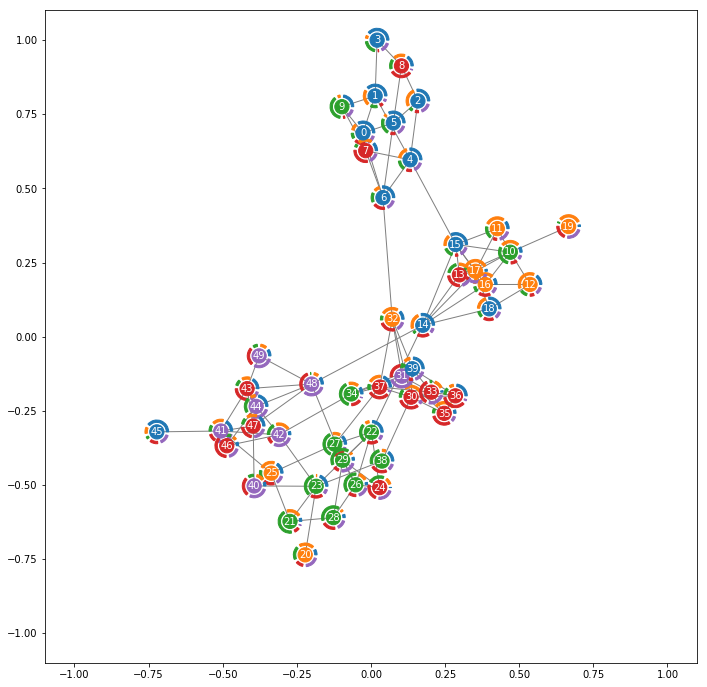

In [6]:
# Parameters
l = 5
k = 10
p_in = .4
p_out = .01
g = nx.planted_partition_graph(l, k, p_in, p_out)

# Show the graph
labels = np.zeros((l * k, l), dtype=np.float32)
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
#features = np.random.random((l * k, l)).astype(np.float32)
features = labels + np.abs(np.random.normal(loc=0.0, scale=1.5, size=(l * k, l))).astype(np.float32)
viz.draw_network(g, labels=features);

## Build the VAE

In [7]:
# VAE Parameters
n_nodes = l * k
adj = nx.adjacency_matrix(g).astype(np.float32)

n_ξ_samples = 5
dim_data, dim_l1, dim_ξ = l, 10, 2
dims = (dim_data, dim_l1, dim_ξ)
use_bias = False


# Actual VAE
q_model, q_codecs = ae.build_q(dims, use_bias=use_bias)
p_builder = ae.build_p_builder(dims, use_bias=use_bias)
vae, vae_codecs = ae.build_vae(
    (q_model, q_codecs),
    p_builder,
    n_ξ_samples,
    [
        1.0,  # q loss
        1.0,  # p adj loss
        1.0,  # p v loss
    ],
)

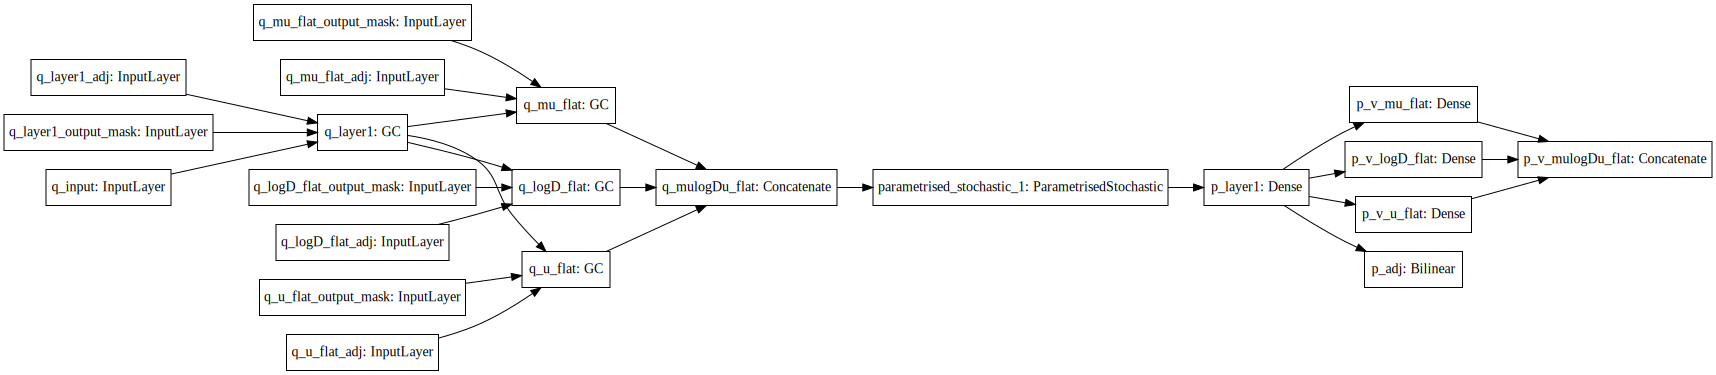

In [8]:
display(SVG(model_to_dot(vae, rankdir='LR').create(prog='dot', format='svg')))

## Target function

In [9]:
features = utils.scale_center(features)

def target_func(batch_adj, required_nodes, final_nodes):
    return [
        np.zeros(1), # ignored
        utils.expand_dims_tile(utils.expand_dims_tile(batch_adj + np.eye(batch_adj.shape[0]), 0, n_ξ_samples), 0, 1),
        utils.expand_dims_tile(features[final_nodes], 1, n_ξ_samples),
    ]

## Before training

$\xi$ averages and distributions for each community, real and predicted adjacency matrices

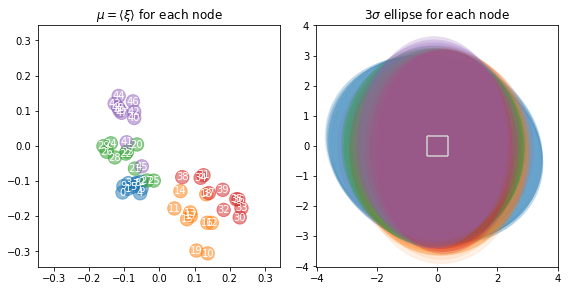

In [10]:
plot_ξ_distribution((g, l, k), q_model, adj, features, with_kdes=False);

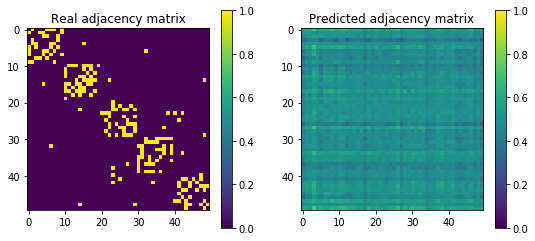

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0]).mean(axis=0))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

## Animate

In [13]:
n_epochs = 1000
seeds_per_batch = n_nodes
max_walk_length = 1
p = 1
q = 1
neighbour_samples = None

steps_per_epoch = int(np.ceil(len(features) / seeds_per_batch))

In [14]:
def build_train_animation():
    ## Plot the first frame
    fig, axes = plt.subplots(2, 4, figsize=(4 * 4, 4 * 2))
    axes[0, -1].set_visible(False)
    _, (mu_circles, mu_texts, sigma_ellipses, box_lines) = plot_ξ_distribution((g, l, k),
                                                                               q_model, adj,
                                                                               features, with_kdes=False, fig=fig)
    x, targets, feeds = next(batching.batches(vae, adj, features, target_func,
                             adj.shape[0], 1,
                             p=1, q=1, neighbour_samples=None))
    q_pred, adj_pred, v_pred = vae.predict_on_fed_batch(x, feeds=feeds)
    adj_im = axes[0, 2].imshow(scipy.special.expit(adj_pred[0]).mean(axis=0))
    axes[0, 2].set_title('Predicted adjacency')
    axes[1, 0].set_title('total loss')
    axes[1, 0].set_xlim(0, n_epochs)
    axes[1, 1].set_title('q_mulogDu_flat_loss')
    axes[1, 1].set_xlim(0, n_epochs)
    axes[1, 2].set_title('p_adj_loss')
    axes[1, 2].set_xlim(0, n_epochs)
    axes[1, 3].set_title('p_v_mulogDu_flat_loss')
    axes[1, 3].set_xlim(0, n_epochs)
    
    ## Prepare outputs
    losses = defaultdict(lambda: np.zeros(n_epochs))
    
    def init_plot():
        return ()

    def train_step(frame):
        t = time.time()
        
        outs = vae.fit_generator_feed(iter([(x, targets, feeds)]),
                                      steps_per_epoch=1,
                                      epochs=1,
                                      check_array_lengths=False,
                                      shuffle=False,
                                      verbose=0,
                                      callbacks=[])
        outs = outs.history
        for name, value in outs.items():
            losses[name][frame] = value[0]
        
        print('Epoch: {:04d}'.format(frame + 1), 'time={:.5f}'.format(time.time() - t),
              *['{}={:.5f}'.format(name, values[0]) for name, values in outs.items()])
        
        ## Plot the update
        q_pred, adj_pred, v_pred = vae.predict_on_fed_batch(x, feeds=feeds)

        # μ plots
        q_pred_μ = q_pred[:, :2]
        max_mu = np.abs(q_pred_μ).max()
        c_radius = max_mu / (20 - 4)
        for circle, text, mu in zip(mu_circles, mu_texts, q_pred_μ):
            circle.center = mu
            circle.radius = c_radius
            text.set_position(mu)
        axes[0, 0].set_xlim(- (max_mu + 2 * c_radius), max_mu + 2 * c_radius)
        axes[0, 0].set_ylim(- (max_mu + 2 * c_radius), max_mu + 2 * c_radius)

        # Ellipse plots
        embedding_codec = codecs.Gaussian(q_pred)
        R = K.eval(embedding_codec.R)
        C = R @ R.transpose([0, 2, 1])

        evals, evecs = zip(*[linalg.eigh(c) for c in C])
        evals = np.array(evals)
        evecs = np.array(evecs)

        e_widths = 3 * 2 * np.sqrt(evals[:, 0])
        e_heights = 3 * 2 * np.sqrt(evals[:, 1])
        e_angles = 180 * np.arctan(evecs[:, 0, 1] / evecs[:, 0, 0]) / np.pi
        
        for ellipse, width, height, angle, mu in zip(sigma_ellipses, e_widths, e_heights, e_angles, q_pred_μ):
            ellipse.width = width
            ellipse.height = height
            ellipse.angle = angle
            ellipse.center = mu
            
        max_ellipse_radius = max(e_widths.max(), e_heights.max()) / 2
        xylim_sigma = max_ellipse_radius + max_mu
        axes[0, 1].set_xlim(-xylim_sigma, xylim_sigma)
        axes[0, 1].set_ylim(-xylim_sigma, xylim_sigma)
        
        # Grey box
        box_lines[0].set_segments([np.array([[x, y] for x in axes[0, 0].get_xlim()])
                                   for y in axes[0, 0].get_ylim()])
        box_lines[1].set_segments([np.array([[x, y] for y in axes[0, 0].get_ylim()])
                                   for x in axes[0, 0].get_xlim()])
        
        # Adjacency matrix
        adj_im.set_array(scipy.special.expit(adj_pred[0]).mean(axis=0))
        
        # Losses
        axes[1, 0].plot(range(frame + 1), losses['loss'][:frame + 1], color=blue)
        axes[1, 1].plot(range(frame + 1), losses['q_mulogDu_flat_loss'][:frame + 1], color=blue)
        axes[1, 2].plot(range(frame + 1), losses['p_adj_loss'][:frame + 1], color=blue)
        axes[1, 3].plot(range(frame + 1), losses['p_v_mulogDu_flat_loss'][:frame + 1], color=blue)

        return ()


    anim = mpl.animation.FuncAnimation(fig, train_step, blit=True,
                                       init_func=init_plot,
                                       interval=100,
                                       save_count=n_epochs,
                                       frames=n_epochs,
                                       repeat=False)
    plt.close()
    return anim, losses

In [ ]:
anim, losses = build_train_animation()
anim.save('gcae.mp4', dpi=150)
#video = anim.to_html5_video()
#display(HTML(video))

/home/slerique/anaconda3/envs/base36-grunchgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/slerique/anaconda3/envs/base36-grunchgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/slerique/anaconda3/envs/base36-grunchgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 0001 time=2.42852 loss=41.85150 q_mulogDu_flat_loss=0.04873 p_adj_loss=35.93513 p_v_mulogDu_flat_loss=5.53713
Epoch: 0002 time=0.01736 loss=41.55743 q_mulogDu_flat_loss=0.04839 p_adj_loss=35.68656 p_v_mulogDu_flat_loss=5.49241
Epoch: 0003 time=0.01596 loss=41.63379 q_mulogDu_flat_loss=0.04803 p_adj_loss=35.75611 p_v_mulogDu_flat_loss=5.50008
Epoch: 0004 time=0.01842 loss=42.17506 q_mulogDu_flat_loss=0.04765 p_adj_loss=36.10552 p_v_mulogDu_flat_loss=5.69283
Epoch: 0005 time=0.01689 loss=41.13840 q_mulogDu_flat_loss=0.04725 p_adj_loss=35.33995 p_v_mulogDu_flat_loss=5.42264
Epoch: 0006 time=0.01847 loss=41.41150 q_mulogDu_flat_loss=0.04688 p_adj_loss=35.46124 p_v_mulogDu_flat_loss=5.57535
Epoch: 0007 time=0.01819 loss=41.24730 q_mulogDu_flat_loss=0.04653 p_adj_loss=35.46764 p_v_mulogDu_flat_loss=5.40561
Epoch: 0008 time=0.01673 loss=42.00162 q_mulogDu_flat_loss=0.04619 p_adj_loss=35.91460 p_v_mulogDu_flat_loss=5.71385
Epoch: 0009 time=0.01805 loss=41.56155 q_mulogDu_flat_loss=0.045

In [14]:
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

NameError: name 'history' is not defined

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

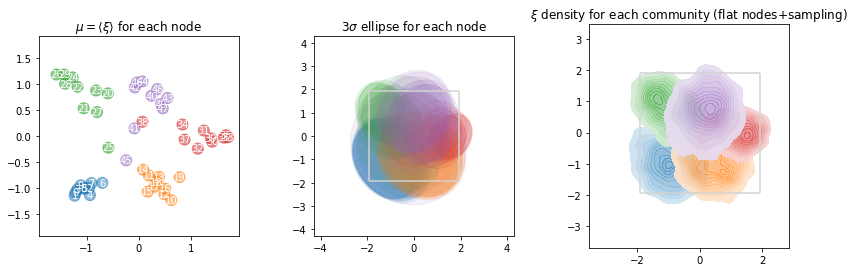

In [18]:
plot_ξ_distribution((g, l, k), q_model, adj, features);

Predicted adjacency matrix:

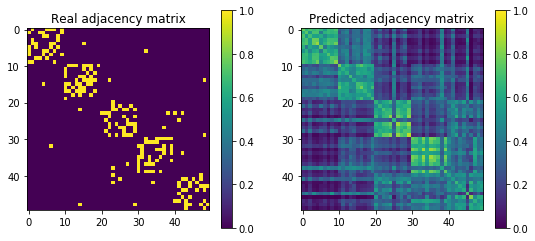

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0]).mean(axis=0))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);